# ENet -  Real Time Semantic Segmentation

In this notebook, we have reproduced the ENet paper. <br/>
Link to the paper: https://arxiv.org/pdf/1606.02147.pdf <br/>
Link to the repository: https://github.com/iArunava/ENet-Real-Time-Semantic-Segmentation


Star and Fork!


**ALL THE CODE IN THIS NOTEBOOK ASSUMES THE USAGE OF THE <span style="color:blue;">CAMVID</span> DATASET**

## Install the dependencies and Import them

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image

## Download the CamVid dataset 

## Create the ENet model

We decided to to split the model to three sub classes:

1) Initial block  

2) RDDNeck - class for regular, downsampling and dilated bottlenecks

3) ASNeck -  class for asymetric bottlenecks

4) UBNeck - class for upsampling bottlenecks

In [2]:
class InitialBlock(nn.Module):
  
  # Initial block of the model:
  #         Input
  #        /     \
  #       /       \
  #maxpool2d    conv2d-3x3
  #       \       /  
  #        \     /
  #      concatenate
   
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        
        side = self.maxpool(x)
        
        # concatenating on the channels axis
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

In [3]:
class UBNeck(nn.Module):
    
  # Upsampling bottleneck:
  #     Bottleneck Input
  #        /        \
  #       /          \
  # conv2d-1x1     convTrans2d-1x1
  #      |             | PReLU
  #      |         convTrans2d-3x3
  #      |             | PReLU
  #      |         convTrans2d-1x1
  #      |             |
  # maxunpool2d    Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  #  Params: 
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        # This layer used for Upsampling
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # summing the main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [4]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
      
  # Regular|Dilated|Downsampling bottlenecks:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  # maxpooling2d   conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-3x3
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params: 
  #  dilation (bool) - if True: creating dilation bottleneck
  #  down_flag (bool) - if True: creating downsampling bottleneck
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  #  p - dropout ratio
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag
        
        # calculating the number of reduced channels
        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [5]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
      
  # Asymetric bottleneck:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  #      |         conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-1x5
  #      |             |
  #      |         conv2d-5x1
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params:    
  #  projection_ratio - ratio between input and output channels
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [6]:
class encoder(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        # C - number of classes
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)

        return x, i1,i2
        
        
        

In [7]:
class decoder(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        # C - number of classes
        self.C = C

        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
    def forward(self, x, i1, i2):
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        
        return x

In [8]:
class ENet(nn.Module):
  
  # Creating Enet model!
  
    def __init__(self, C):
        super().__init__()
        
        self.encoder = encoder(C)
        
        # Create the decoder
        self.decoder = decoder(C)

    def forward(self, x):
        # Pass input through the encoder
        encoder_output, i1, i2 = self.encoder(x)

        # Pass encoder output and intermediate feature maps to the decoder
        decoder_output = self.decoder(encoder_output, i1, i2)

        return decoder_output

        

## Instantiate the ENet model

Move the model to cuda if available

In [9]:
# Checking if there is any gpu available and pass the model to gpu or cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

enet = ENet(2)

print(device)

cuda:0


## Define the loader that will load the input and output images

In [10]:
def loader(training_path, segmented_path, batch_size, h=360, w=480):
    filenames_t = os.listdir(training_path)
    total_files_t = len(filenames_t)
    
    filenames_s = os.listdir(segmented_path)
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    
    road_idx = 3
    while(1):
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
            
        inputs = []
        labels = []
        
        for jj in batch_idxs:
            img = plt.imread(training_path + filenames_t[jj])
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            inputs.append(img)
            
            label_img = cv2.imread(segmented_path +filenames_s[jj], cv2.IMREAD_UNCHANGED)            
            road_mask = (label_img == road_idx).astype(np.uint8)
            road_mask = cv2.resize(road_mask, (h, w), cv2.INTER_NEAREST)
            labels.append(road_mask)
         
        inputs = np.stack(inputs, axis=2)
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        labels = torch.tensor(labels)
        #print('label ', labels.shape)
        
        yield inputs, labels

## IoU functions

In [11]:
def intersection_over_union(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).sum().item()
    union = torch.logical_or(pred_mask, true_mask).sum().item()

    iou = intersection / union if union > 0 else 0.0
    return iou

def mean_iou(predictions, targets, num_classes):
    class_iou = [0] * num_classes
    
    for class_idx in range(num_classes):
        pred_mask = (predictions == class_idx)
        true_mask = (targets == class_idx)
        class_iou[class_idx] = intersection_over_union(pred_mask, true_mask)

    mean_iou_value = sum(class_iou) / num_classes
    
    return mean_iou_value


def calculate_mIoU(model, inputs, labels, device, num_classes):
    model.eval()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)

        batch_iou = mean_iou(predictions, labels, num_classes)
        mIoU = batch_iou
    return mIoU




## Define the class weights

In [12]:
def get_class_weights(pipe,num_classes, c=1.02):
    _, labels = next(pipe)
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [13]:
pipe = loader('/kaggle/input/camvid-segmap/CamVid/train/', '/kaggle/input/camvid-segmap/CamVid/trainannot/', batch_size='all')



In [15]:
class_weights = get_class_weights(pipe,2)
print(class_weights)


/tmp/ipykernel_27/3805452149.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor(labels)


[1.8800411  3.43583914]


## Define the Hyperparameters

In [17]:
lr = 5e-5
batch_size = 10

criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=2e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)


#epochs = 100
save_every = 100
#eval_every = 50



In [ ]:
train_losses = []
eval_losses = []
eval_acc = []
test_losses = []
test_acc = []

batch_size = 10
bc_train = 367 // batch_size # mini_batch train
bc_eval = 101 // batch_size  # mini_batch validation
bc_test = 233 // batch_size


# Define pipeline objects
pipe = loader('/kaggle/input/camvid-segmap/CamVid/train/', '/kaggle/input/camvid-segmap/CamVid/trainannot/', batch_size)
eval_pipe = loader('/kaggle/input/camvid-segmap/CamVid/val/', '/kaggle/input/camvid-segmap/CamVid/valannot/', batch_size)



## Training loop

In [26]:

# Train loop
def train (model,epochs, pipe, eval_pipe, criterion, optimizer, scheduler, device):
    model.to(device)
    for e in range(1, epochs+1):
    
        if (epochs<60):
            for param in enet.decoder.parameters():
                param.requires_grad = False
        else:
            for param in enet.decoder.parameters():
                param.requires_grad = False
            
        train_loss = 0
        print ('-'*15,'Epoch %d' % e, '-'*15)
    
        enet.train()
    
        for _ in tqdm(range(bc_train)):
            X_batch, mask_batch = next(pipe)
        
            # assign data to cpu/gpu
            X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

            optimizer.zero_grad()

            out = enet(X_batch.float())
            #print(mask_batch.shape)
            #print( 'pred ',out.shape)
        
            # loss calculation
            loss = criterion(out, mask_batch.long())
            # update weights
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss/batch_size)
    
    
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0
            cum_eval_iou =0
        
            # Validation loop
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)
                
                inputs, labels = inputs.to(device), labels.to(device)
                    
                out = enet(inputs)
                loss = criterion(out, labels.long())
                eval_loss += loss.item()
            
                cum_eval_iou += calculate_mIoU(enet, inputs, labels, device, 2)            
   
        eval_losses.append(eval_loss/batch_size)
        eval_acc.append(cum_eval_iou/batch_size)
        print ('Epoch {}/{}...'.format(e, epochs),
                'train_Loss {:6f}'.format(train_losses[-1]),
                'eval_Loss {:6f}'.format(eval_losses[-1]),
                'eval_acc {:6f}'.format(eval_acc[-1]))
        
        scheduler.step(eval_loss/bc_eval)
        if e % save_every == 0:
            checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict(),
            'train_error' :train_losses,
            'val_error' : eval_losses,
            'iou_trend' : eval_acc,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'class_weights' : class_weights
            }
            torch.save(checkpoint, './ckpt-enet-camvid-{}-{}.pth'.format(e, train_loss))
            print ('Model saved!')
            
        print(f'current learning rate: {optimizer.param_groups[0]["lr"]}')
        
        print ('Epoch {}/{}...'.format(e, epochs),
           'Total Mean train Loss: {:6f}'.format(sum(train_losses) / e))
    return train_losses, eval_losses, eval_acc

In [27]:
train_losses, eval_losses, eval_acc = train(enet,epochs, pipe, eval_pipe, criterion, optimizer, scheduler, device )

--------------- Epoch 1 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 1/100... train_Loss 0.258031 eval_Loss 1.405010 eval_acc 0.354458
current learning rate: 0.0005
Epoch 1/100... Total Mean train Loss: 0.258031
--------------- Epoch 2 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 2/100... train_Loss 0.205874 eval_Loss 1.634923 eval_acc 0.355914
current learning rate: 0.0005
Epoch 2/100... Total Mean train Loss: 0.231953
--------------- Epoch 3 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 3/100... train_Loss 0.179666 eval_Loss 1.728600 eval_acc 0.357582
current learning rate: 0.0005
Epoch 3/100... Total Mean train Loss: 0.214524
--------------- Epoch 4 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 4/100... train_Loss 0.169729 eval_Loss 1.859399 eval_acc 0.357125
current learning rate: 0.0005
Epoch 4/100... Total Mean train Loss: 0.203325
--------------- Epoch 5 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 5/100... train_Loss 0.162498 eval_Loss 1.779542 eval_acc 0.355307
current learning rate: 0.0005
Epoch 5/100... Total Mean train Loss: 0.195160
--------------- Epoch 6 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 6/100... train_Loss 0.147358 eval_Loss 1.826880 eval_acc 0.357082
current learning rate: 0.0005
Epoch 6/100... Total Mean train Loss: 0.187193
--------------- Epoch 7 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 7/100... train_Loss 0.142673 eval_Loss 2.179802 eval_acc 0.354858
current learning rate: 0.0005
Epoch 7/100... Total Mean train Loss: 0.180833
--------------- Epoch 8 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 8/100... train_Loss 0.132086 eval_Loss 1.882454 eval_acc 0.352398
current learning rate: 0.0005
Epoch 8/100... Total Mean train Loss: 0.174739
--------------- Epoch 9 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 9/100... train_Loss 0.126612 eval_Loss 1.755254 eval_acc 0.355490
current learning rate: 0.0005
Epoch 9/100... Total Mean train Loss: 0.169392
--------------- Epoch 10 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 10/100... train_Loss 0.114077 eval_Loss 1.719331 eval_acc 0.352757
current learning rate: 0.0005
Epoch 10/100... Total Mean train Loss: 0.163861
--------------- Epoch 11 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 11/100... train_Loss 0.122160 eval_Loss 1.996822 eval_acc 0.353467
current learning rate: 0.0005
Epoch 11/100... Total Mean train Loss: 0.160070
--------------- Epoch 12 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 12/100... train_Loss 0.127820 eval_Loss 1.450255 eval_acc 0.353909
current learning rate: 0.0005
Epoch 12/100... Total Mean train Loss: 0.157382
--------------- Epoch 13 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 13/100... train_Loss 0.111013 eval_Loss 1.637468 eval_acc 0.354923
current learning rate: 0.0005
Epoch 13/100... Total Mean train Loss: 0.153815
--------------- Epoch 14 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Epoch 14/100... train_Loss 0.112489 eval_Loss 1.395265 eval_acc 0.354432
current learning rate: 0.0005
Epoch 14/100... Total Mean train Loss: 0.150863
--------------- Epoch 15 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 15/100... train_Loss 0.101424 eval_Loss 1.613336 eval_acc 0.352101
current learning rate: 0.0005
Epoch 15/100... Total Mean train Loss: 0.147567
--------------- Epoch 16 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 16/100... train_Loss 0.161809 eval_Loss 1.536547 eval_acc 0.359778
current learning rate: 0.0005
Epoch 16/100... Total Mean train Loss: 0.148458
--------------- Epoch 17 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 17/100... train_Loss 0.134224 eval_Loss 1.538400 eval_acc 0.355483
current learning rate: 0.0005
Epoch 17/100... Total Mean train Loss: 0.147620
--------------- Epoch 18 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 18/100... train_Loss 0.115797 eval_Loss 1.571677 eval_acc 0.356861
current learning rate: 0.0005
Epoch 18/100... Total Mean train Loss: 0.145852
--------------- Epoch 19 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 19/100... train_Loss 0.100557 eval_Loss 1.738941 eval_acc 0.356462
current learning rate: 0.0005
Epoch 19/100... Total Mean train Loss: 0.143468
--------------- Epoch 20 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 20/100... train_Loss 0.091352 eval_Loss 1.553521 eval_acc 0.356564
current learning rate: 0.0005
Epoch 20/100... Total Mean train Loss: 0.140863
--------------- Epoch 21 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 21/100... train_Loss 0.093852 eval_Loss 1.636149 eval_acc 0.355332
current learning rate: 0.0005
Epoch 21/100... Total Mean train Loss: 0.138624
--------------- Epoch 22 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 22/100... train_Loss 0.096528 eval_Loss 1.394265 eval_acc 0.356658
current learning rate: 0.0005
Epoch 22/100... Total Mean train Loss: 0.136711
--------------- Epoch 23 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 23/100... train_Loss 0.098428 eval_Loss 1.411469 eval_acc 0.358200
current learning rate: 0.0005
Epoch 23/100... Total Mean train Loss: 0.135046
--------------- Epoch 24 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 24/100... train_Loss 0.089499 eval_Loss 1.583842 eval_acc 0.356716
current learning rate: 0.0005
Epoch 24/100... Total Mean train Loss: 0.133148
--------------- Epoch 25 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 25/100... train_Loss 0.098585 eval_Loss 1.272541 eval_acc 0.357414
Model saved!
current learning rate: 0.0005
Epoch 25/100... Total Mean train Loss: 0.131766
--------------- Epoch 26 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 26/100... train_Loss 0.094209 eval_Loss 1.332158 eval_acc 0.353309
current learning rate: 0.0005
Epoch 26/100... Total Mean train Loss: 0.130321
--------------- Epoch 27 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 27/100... train_Loss 0.083463 eval_Loss 1.354735 eval_acc 0.355345
current learning rate: 0.0005
Epoch 27/100... Total Mean train Loss: 0.128586
--------------- Epoch 28 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 28/100... train_Loss 0.075699 eval_Loss 1.331755 eval_acc 0.354623
current learning rate: 0.0005
Epoch 28/100... Total Mean train Loss: 0.126697
--------------- Epoch 29 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 29/100... train_Loss 0.076005 eval_Loss 1.348326 eval_acc 0.356032
current learning rate: 0.0005
Epoch 29/100... Total Mean train Loss: 0.124949
--------------- Epoch 30 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 30/100... train_Loss 0.075188 eval_Loss 1.378971 eval_acc 0.354861
current learning rate: 0.0005
Epoch 30/100... Total Mean train Loss: 0.123290
--------------- Epoch 31 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 31/100... train_Loss 0.071040 eval_Loss 1.447380 eval_acc 0.356335
current learning rate: 0.0005
Epoch 31/100... Total Mean train Loss: 0.121605
--------------- Epoch 32 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 32/100... train_Loss 0.080193 eval_Loss 1.555019 eval_acc 0.356047
current learning rate: 0.0005
Epoch 32/100... Total Mean train Loss: 0.120311
--------------- Epoch 33 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


Epoch 33/100... train_Loss 0.078024 eval_Loss 1.460248 eval_acc 0.355764
current learning rate: 0.0005
Epoch 33/100... Total Mean train Loss: 0.119029
--------------- Epoch 34 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 34/100... train_Loss 0.071154 eval_Loss 1.391671 eval_acc 0.351359
current learning rate: 0.0005
Epoch 34/100... Total Mean train Loss: 0.117621
--------------- Epoch 35 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 35/100... train_Loss 0.077298 eval_Loss 1.161545 eval_acc 0.353550
current learning rate: 0.0005
Epoch 35/100... Total Mean train Loss: 0.116469
--------------- Epoch 36 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 36/100... train_Loss 0.134800 eval_Loss 1.497178 eval_acc 0.356218
current learning rate: 0.0005
Epoch 36/100... Total Mean train Loss: 0.116978
--------------- Epoch 37 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 37/100... train_Loss 0.108163 eval_Loss 1.668806 eval_acc 0.353891
current learning rate: 0.0005
Epoch 37/100... Total Mean train Loss: 0.116740
--------------- Epoch 38 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 38/100... train_Loss 0.095961 eval_Loss 1.591710 eval_acc 0.354278
current learning rate: 0.0005
Epoch 38/100... Total Mean train Loss: 0.116193
--------------- Epoch 39 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 39/100... train_Loss 0.084731 eval_Loss 1.440984 eval_acc 0.356763
current learning rate: 0.0005
Epoch 39/100... Total Mean train Loss: 0.115386
--------------- Epoch 40 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 40/100... train_Loss 0.076749 eval_Loss 1.523419 eval_acc 0.356010
current learning rate: 0.0005
Epoch 40/100... Total Mean train Loss: 0.114421
--------------- Epoch 41 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 41/100... train_Loss 0.071701 eval_Loss 1.553780 eval_acc 0.355300
current learning rate: 0.0005
Epoch 41/100... Total Mean train Loss: 0.113379
--------------- Epoch 42 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 42/100... train_Loss 0.067411 eval_Loss 1.486645 eval_acc 0.356534
current learning rate: 0.0005
Epoch 42/100... Total Mean train Loss: 0.112284
--------------- Epoch 43 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 43/100... train_Loss 0.076292 eval_Loss 1.544493 eval_acc 0.353571
current learning rate: 0.0005
Epoch 43/100... Total Mean train Loss: 0.111447
--------------- Epoch 44 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 44/100... train_Loss 0.075222 eval_Loss 1.531148 eval_acc 0.355775
current learning rate: 0.0005
Epoch 44/100... Total Mean train Loss: 0.110624
--------------- Epoch 45 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 45/100... train_Loss 0.067382 eval_Loss 1.724921 eval_acc 0.353356
current learning rate: 0.0005
Epoch 45/100... Total Mean train Loss: 0.109663
--------------- Epoch 46 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 46/100... train_Loss 0.068459 eval_Loss 1.635912 eval_acc 0.354678
current learning rate: 0.0005
Epoch 46/100... Total Mean train Loss: 0.108767
--------------- Epoch 47 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


Epoch 47/100... train_Loss 0.062744 eval_Loss 1.610470 eval_acc 0.356073
current learning rate: 0.0005
Epoch 47/100... Total Mean train Loss: 0.107788
--------------- Epoch 48 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 48/100... train_Loss 0.061099 eval_Loss 1.678339 eval_acc 0.356660
current learning rate: 0.0005
Epoch 48/100... Total Mean train Loss: 0.106815
--------------- Epoch 49 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 49/100... train_Loss 0.067127 eval_Loss 1.569972 eval_acc 0.357756
current learning rate: 0.0005
Epoch 49/100... Total Mean train Loss: 0.106005
--------------- Epoch 50 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 50/100... train_Loss 0.070036 eval_Loss 1.751645 eval_acc 0.355416
Model saved!
current learning rate: 0.0005
Epoch 50/100... Total Mean train Loss: 0.105286
--------------- Epoch 51 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 51/100... train_Loss 0.063227 eval_Loss 1.696407 eval_acc 0.356839
current learning rate: 0.0005
Epoch 51/100... Total Mean train Loss: 0.104461
--------------- Epoch 52 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 52/100... train_Loss 0.058421 eval_Loss 1.705183 eval_acc 0.353039
current learning rate: 0.0005
Epoch 52/100... Total Mean train Loss: 0.103576
--------------- Epoch 53 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 53/100... train_Loss 0.056559 eval_Loss 1.725381 eval_acc 0.356664
current learning rate: 0.0005
Epoch 53/100... Total Mean train Loss: 0.102689
--------------- Epoch 54 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 54/100... train_Loss 0.056177 eval_Loss 1.674505 eval_acc 0.356138
current learning rate: 0.0005
Epoch 54/100... Total Mean train Loss: 0.101827
--------------- Epoch 55 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 55/100... train_Loss 0.054637 eval_Loss 1.776291 eval_acc 0.357652
current learning rate: 0.0005
Epoch 55/100... Total Mean train Loss: 0.100969
--------------- Epoch 56 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 56/100... train_Loss 0.058635 eval_Loss 1.724604 eval_acc 0.355651
current learning rate: 0.0005
Epoch 56/100... Total Mean train Loss: 0.100213
--------------- Epoch 57 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 57/100... train_Loss 0.073479 eval_Loss 1.745129 eval_acc 0.357004
current learning rate: 0.0005
Epoch 57/100... Total Mean train Loss: 0.099744
--------------- Epoch 58 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 58/100... train_Loss 0.088904 eval_Loss 1.659109 eval_acc 0.354859
current learning rate: 0.0005
Epoch 58/100... Total Mean train Loss: 0.099557
--------------- Epoch 59 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 59/100... train_Loss 0.085720 eval_Loss 1.610394 eval_acc 0.353587
current learning rate: 0.0005
Epoch 59/100... Total Mean train Loss: 0.099323
--------------- Epoch 60 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 60/100... train_Loss 0.107497 eval_Loss 1.901552 eval_acc 0.355813
current learning rate: 0.0005
Epoch 60/100... Total Mean train Loss: 0.099459
--------------- Epoch 61 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 61/100... train_Loss 0.102119 eval_Loss 1.750975 eval_acc 0.353191
current learning rate: 0.0005
Epoch 61/100... Total Mean train Loss: 0.099503
--------------- Epoch 62 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 62/100... train_Loss 0.090991 eval_Loss 1.805598 eval_acc 0.355016
current learning rate: 0.0005
Epoch 62/100... Total Mean train Loss: 0.099365
--------------- Epoch 63 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 63/100... train_Loss 0.078256 eval_Loss 1.861860 eval_acc 0.355862
current learning rate: 0.0005
Epoch 63/100... Total Mean train Loss: 0.099030
--------------- Epoch 64 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 64/100... train_Loss 0.065803 eval_Loss 1.865751 eval_acc 0.356866
current learning rate: 0.0005
Epoch 64/100... Total Mean train Loss: 0.098511
--------------- Epoch 65 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 65/100... train_Loss 0.067927 eval_Loss 1.848272 eval_acc 0.357568
current learning rate: 0.0005
Epoch 65/100... Total Mean train Loss: 0.098041
--------------- Epoch 66 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 66/100... train_Loss 0.062428 eval_Loss 1.892370 eval_acc 0.354663
current learning rate: 0.0005
Epoch 66/100... Total Mean train Loss: 0.097501
--------------- Epoch 67 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 67/100... train_Loss 0.057509 eval_Loss 1.882512 eval_acc 0.356091
current learning rate: 0.0005
Epoch 67/100... Total Mean train Loss: 0.096904
--------------- Epoch 68 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Epoch 68/100... train_Loss 0.056853 eval_Loss 1.877666 eval_acc 0.356232
current learning rate: 0.0005
Epoch 68/100... Total Mean train Loss: 0.096315
--------------- Epoch 69 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 69/100... train_Loss 0.055311 eval_Loss 1.806938 eval_acc 0.357384
current learning rate: 0.0005
Epoch 69/100... Total Mean train Loss: 0.095721
--------------- Epoch 70 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 70/100... train_Loss 0.052479 eval_Loss 1.868249 eval_acc 0.355971
current learning rate: 0.0005
Epoch 70/100... Total Mean train Loss: 0.095103
--------------- Epoch 71 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 71/100... train_Loss 0.053795 eval_Loss 1.877017 eval_acc 0.353776
current learning rate: 0.0005
Epoch 71/100... Total Mean train Loss: 0.094521
--------------- Epoch 72 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 72/100... train_Loss 0.050923 eval_Loss 1.956472 eval_acc 0.357647
current learning rate: 0.0005
Epoch 72/100... Total Mean train Loss: 0.093916
--------------- Epoch 73 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 73/100... train_Loss 0.048499 eval_Loss 1.860441 eval_acc 0.354803
current learning rate: 0.0005
Epoch 73/100... Total Mean train Loss: 0.093294
--------------- Epoch 74 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 74/100... train_Loss 0.050903 eval_Loss 1.844255 eval_acc 0.355867
current learning rate: 0.0005
Epoch 74/100... Total Mean train Loss: 0.092721
--------------- Epoch 75 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 75/100... train_Loss 0.051919 eval_Loss 1.758773 eval_acc 0.356640
Model saved!
current learning rate: 0.0005
Epoch 75/100... Total Mean train Loss: 0.092177
--------------- Epoch 76 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 76/100... train_Loss 0.050756 eval_Loss 1.887912 eval_acc 0.355678
current learning rate: 0.0005
Epoch 76/100... Total Mean train Loss: 0.091632
--------------- Epoch 77 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 77/100... train_Loss 0.048832 eval_Loss 1.863579 eval_acc 0.355049
current learning rate: 0.0005
Epoch 77/100... Total Mean train Loss: 0.091076
--------------- Epoch 78 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 78/100... train_Loss 0.047981 eval_Loss 1.906201 eval_acc 0.356733
current learning rate: 0.0005
Epoch 78/100... Total Mean train Loss: 0.090523
--------------- Epoch 79 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 79/100... train_Loss 0.049059 eval_Loss 1.864340 eval_acc 0.355068
current learning rate: 0.0005
Epoch 79/100... Total Mean train Loss: 0.089999
--------------- Epoch 80 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 80/100... train_Loss 0.051783 eval_Loss 1.839897 eval_acc 0.354780
current learning rate: 0.0005
Epoch 80/100... Total Mean train Loss: 0.089521
--------------- Epoch 81 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 81/100... train_Loss 0.052770 eval_Loss 1.869457 eval_acc 0.355518
current learning rate: 0.0005
Epoch 81/100... Total Mean train Loss: 0.089067
--------------- Epoch 82 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 82/100... train_Loss 0.050654 eval_Loss 2.062072 eval_acc 0.356061
current learning rate: 0.0005
Epoch 82/100... Total Mean train Loss: 0.088599
--------------- Epoch 83 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 83/100... train_Loss 0.046964 eval_Loss 1.977472 eval_acc 0.355956
current learning rate: 0.0005
Epoch 83/100... Total Mean train Loss: 0.088097
--------------- Epoch 84 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Epoch 84/100... train_Loss 0.048979 eval_Loss 1.948187 eval_acc 0.355333
current learning rate: 0.0005
Epoch 84/100... Total Mean train Loss: 0.087631
--------------- Epoch 85 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 85/100... train_Loss 0.052284 eval_Loss 1.944868 eval_acc 0.354921
current learning rate: 0.0005
Epoch 85/100... Total Mean train Loss: 0.087216
--------------- Epoch 86 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Epoch 86/100... train_Loss 0.051090 eval_Loss 1.934059 eval_acc 0.356742
Epoch 00086: reducing learning rate of group 0 to 5.0000e-05.
current learning rate: 5e-05
Epoch 86/100... Total Mean train Loss: 0.086795
--------------- Epoch 87 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 87/100... train_Loss 0.049649 eval_Loss 1.948170 eval_acc 0.355032
current learning rate: 5e-05
Epoch 87/100... Total Mean train Loss: 0.086369
--------------- Epoch 88 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 88/100... train_Loss 0.044490 eval_Loss 1.912763 eval_acc 0.357344
current learning rate: 5e-05
Epoch 88/100... Total Mean train Loss: 0.085893
--------------- Epoch 89 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 89/100... train_Loss 0.042562 eval_Loss 1.981973 eval_acc 0.355849
current learning rate: 5e-05
Epoch 89/100... Total Mean train Loss: 0.085406
--------------- Epoch 90 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Epoch 90/100... train_Loss 0.042416 eval_Loss 1.965534 eval_acc 0.352469
current learning rate: 5e-05
Epoch 90/100... Total Mean train Loss: 0.084928
--------------- Epoch 91 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Epoch 91/100... train_Loss 0.041205 eval_Loss 1.890684 eval_acc 0.356327
current learning rate: 5e-05
Epoch 91/100... Total Mean train Loss: 0.084448
--------------- Epoch 92 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch 92/100... train_Loss 0.043124 eval_Loss 1.983696 eval_acc 0.354255
current learning rate: 5e-05
Epoch 92/100... Total Mean train Loss: 0.083998
--------------- Epoch 93 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 93/100... train_Loss 0.041686 eval_Loss 1.971914 eval_acc 0.354541
current learning rate: 5e-05
Epoch 93/100... Total Mean train Loss: 0.083543
--------------- Epoch 94 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Epoch 94/100... train_Loss 0.039179 eval_Loss 1.881745 eval_acc 0.356897
current learning rate: 5e-05
Epoch 94/100... Total Mean train Loss: 0.083072
--------------- Epoch 95 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 95/100... train_Loss 0.042035 eval_Loss 1.824735 eval_acc 0.353776
current learning rate: 5e-05
Epoch 95/100... Total Mean train Loss: 0.082640
--------------- Epoch 96 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Epoch 96/100... train_Loss 0.040619 eval_Loss 1.952202 eval_acc 0.354814
current learning rate: 5e-05
Epoch 96/100... Total Mean train Loss: 0.082202
--------------- Epoch 97 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Epoch 97/100... train_Loss 0.039488 eval_Loss 1.912521 eval_acc 0.353702
current learning rate: 5e-05
Epoch 97/100... Total Mean train Loss: 0.081762
--------------- Epoch 98 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Epoch 98/100... train_Loss 0.040232 eval_Loss 1.976589 eval_acc 0.353704
current learning rate: 5e-05
Epoch 98/100... Total Mean train Loss: 0.081338
--------------- Epoch 99 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 99/100... train_Loss 0.039664 eval_Loss 1.850151 eval_acc 0.355758
current learning rate: 5e-05
Epoch 99/100... Total Mean train Loss: 0.080917
--------------- Epoch 100 ---------------


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

Epoch 100/100... train_Loss 0.038580 eval_Loss 1.976837 eval_acc 0.353251
Model saved!
current learning rate: 5e-05
Epoch 100/100... Total Mean train Loss: 0.080493


Text(0.5, 1.0, 'Training and Validation losses trend')

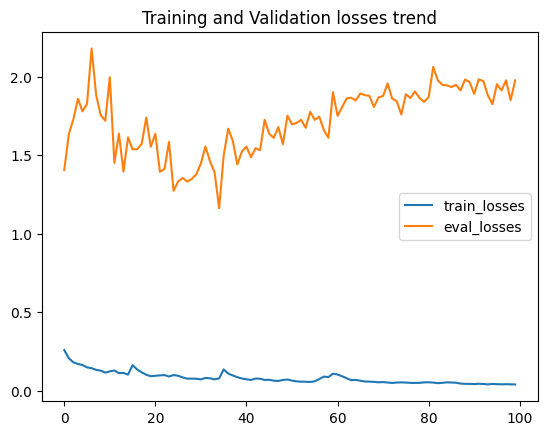

In [29]:

plt.plot(train_losses, label='train_losses')
plt.plot(eval_losses, label = 'eval_losses')
plt.legend(frameon = True)
plt.title('Training and Validation losses trend')



In [30]:
test_pipe = loader('/kaggle/input/camvid-segmap/CamVid/test/', '/kaggle/input/camvid-segmap/CamVid/testannot/', batch_size)


In [ ]:

def test_model(model, epochs,testloaders, criterion, optimizer, scheduler,device):
    
    for e in range(1,epochs):
        enet.to(device)
        with torch.no_grad():
            enet.eval()
            
        test_loss = 0
        cum_test_iou = 0
        # test loop
        for _ in tqdm(range(bc_test)):
            inputs, labels = next(test_pipe)
                
            inputs, labels = inputs.to(device), labels.to(device)
                    
            out = enet(inputs)
            loss = criterion(out, labels.long())
            test_loss += loss.item()
            cum_test_iou += calculate_IoU(enet, inputs, labels, device)
          
            #print ('testLoss {:6f}'.format(test_loss))
        
        test_losses.append(test_loss/bc_test)
        test_acc.append(cum_test_iou/bc_test)
        
        print ('Epoch {}/{}...'.format(e, epochs),
                'eval_Loss {:6f}'.format(test_loss),
                'test_acc{:4f}'.format(test_acc[-1]))
    return test_losses, test_acc
        
      

In [ ]:
test_losses, test_acc = test_model(enet, epochs,test_pipe, criterion, optimizer, scheduler, device)

In [ ]:
plt.plot(train_losses, label='train_losses')
plt.plot(eval_losses, label='valid_losses')

# Move the test_losses tensor to the CPU before plotting
# Convert the test_losses list to a NumPy array before plotting
plt.plot(np.array(test_losses), label='test_losses')

plt.legend(frameon=True)
plt.title('Training, Validation, and Test Losses trend')
plt.show()


Text(0.5, 1.0, 'Validation and Test Accuracy trend')

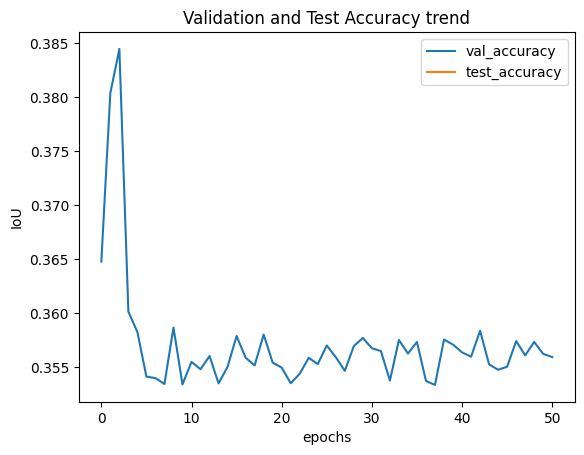

In [19]:

plt.plot(eval_acc, label = 'val_accuracy')
plt.plot(test_acc, label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('IoU')
plt.legend(frameon= True)
plt.title('Validation and Test Accuracy trend')



## Infer using the trained model

Get the PreTrained ENet model

In [48]:
def decode_segmap(image):
    road_color = [255, 0, 255]  # Magenta for road
    non_road_color = [255, 0, 0]  # Red for non-road

    # Create an RGB image with all pixels set to the non-road color
    rgb = np.ones((image.shape[0], image.shape[1], 3), dtype=np.uint8) * non_road_color

    # Set pixels belonging to the road to the road color
    rgb[image == 1] = road_color

    return rgb

In [49]:
def show_images(images, in_row=True):
    '''
    Helper function to show 3 images
    '''
    total_images = len(images)

    rc_tuple = (1, total_images)
    if not in_row:
        rc_tuple = (total_images, 1)
    
    #figure = plt.figure(figsize=(20, 10))
    for ii in range(len(images)):
        plt.subplot(*rc_tuple, ii+1)
        plt.title(images[ii][0])
        plt.axis('off')
        plt.imshow(images[ii][1])
    plt.show()

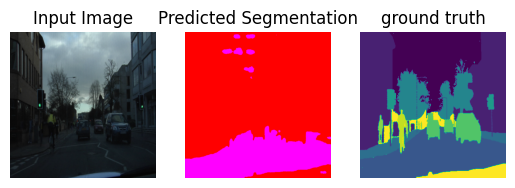

In [55]:
h = 512
w = 512
image_path = '/kaggle/input/camvid-segmap/CamVid/test/0001TP_008550.png'

checkpoint = torch.load('/kaggle/input/checkpoint/ckpt-enet-camvid-75-0.5191921200603247.pth')
    
# Assuming the dataset is camvid
enet = ENet(2)
enet = enet.to(device)
state_dict = checkpoint['state_dict']
enet.load_state_dict(state_dict)

tmg_ = plt.imread(image_path)
tmg_ = cv2.resize(tmg_, (h, w), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2)
tmg = tmg.to(device)

with torch.no_grad():
    out1 = enet(tmg.float()).squeeze(0)
    
b_ = out1.data.max(0)[1].cpu().numpy()

decoded_segmap = decode_segmap(b_)

#smg_ = Image.open('/content/training/semantic/' + fname)
#smg_ = cv2.resize(np.array(smg_), (512, 512), cv2.INTER_NEAREST)
gt_path = image_path.replace('test','testannot') 
gt = plt.imread(gt_path)
gt = cv2.resize(gt, (h, w), cv2.INTER_NEAREST)

images = {
 0 : ['Input Image', tmg_],
 1 : ['Predicted Segmentation', decoded_segmap],
 2 : ['ground truth', gt]
}

show_images(images)


## Loading and retraining the model

In [27]:


def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    start_epoch = checkpoint['epochs']
    eval_losses = checkpoint['val_error']
    train_losses = checkpoint['train_error']
    eval_acc = checkpoint['iou_trend']
    model = ENet(2)
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model,train_losses,eval_losses,start_epoch,eval_acc



In [28]:
checkpoint_path = '/kaggle/input/checkpoint/ckpt-enet-camvid-75-0.5191921200603247.pth'

loaded_model,train_losses,eval_losses,start_epoch,eval_acc  = load_checkpoint(checkpoint_path)
lr = 5e-5

In [43]:
def retrain(model,epochs,next_end, optimizer, scheduler, pipe, eval_pipe ):
    model.to(device)
    
    for e in range(epochs, next_end):
        if (e<500):
            for param in enet.decoder.parameters():
                param.requires_grad = False
        else:
            for param in enet.decoder.parameters():
                param.requires_grad = True
        
        train_loss = 0
        print ('-'*15,'Epoch %d' % e, '-'*15)
    
        model.train()
    
        for _ in tqdm(range(bc_train)):
            X_batch, mask_batch = next(pipe)
        
            # assign data to cpu/gpu
            X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)
            
            optimizer.zero_grad()

            out = model(X_batch.float())
            #out.to(device)
            #print(mask_batch.shape)
            #print( 'pred ',out.shape)
        
            # loss calculation
            loss = criterion(out, mask_batch.long())
            # update weights
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss/batch_size)
    
        with torch.no_grad():
            model.eval()
            
            eval_loss = 0
            cum_eval_iou =0
        
            # Validation loop
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)
                
                inputs, labels = inputs.to(device), labels.to(device)
                    
                out = model(inputs)
                #out.to(device)
                loss = criterion(out, labels.long())
                eval_loss += loss.item()
            
                cum_eval_iou += calculate_mIoU(model, inputs, labels, device, 2)            
   
        eval_losses.append(eval_loss/batch_size)
        eval_acc.append(cum_eval_iou/batch_size)
        print ('Epoch {}/{}...'.format(e, epochs),
                'train_Loss {:6f}'.format(train_losses[-1]),
                'eval_Loss {:6f}'.format(eval_losses[-1]),
                'eval_acc {:6f}'.format(eval_acc[-1]))
        
        scheduler.step(eval_loss/bc_eval)
        if e % save_every == 0:
            checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict(),
            'train_error' :train_losses,
            'val_error' : eval_losses,
            'iou_trend' : eval_acc,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'class_weights' : class_weights
            }
            torch.save(checkpoint, './ckpt-enet-camvid-{}-{}.pth'.format(e, train_loss))
            print ('Model saved!')
            
        print(f'current learning rate: {optimizer.param_groups[0]["lr"]}')
        
        print ('Epoch {}/{}...'.format(e, next_end),
           'Total Mean train Loss: {:6f}'.format(sum(train_losses) / e))
    return train_losses, eval_losses, eval_acc
    

In [45]:
batch_size = 10
bc_train = 367 // batch_size # mini_batch train
bc_eval = 101 // batch_size  # mini_batch validation
bc_test = 233 // batch_size
batch_size = 10
pipe = loader('/kaggle/input/camvid-segmap/CamVid/train/', '/kaggle/input/camvid-segmap/CamVid/trainannot/', batch_size)
eval_pipe = loader('/kaggle/input/camvid-segmap/CamVid/val/', '/kaggle/input/camvid-segmap/CamVid/valannot/', batch_size)

train_losses, eval_losses, eval_acc = retrain(loaded_model,start_epoch,2000, optimizer, scheduler, pipe, eval_pipe)

--------------- Epoch 75 ---------------


  6%|▌         | 2/36 [00:02<00:35,  1.05s/it]


KeyboardInterrupt: 

NameError: name 'test_losses' is not defined

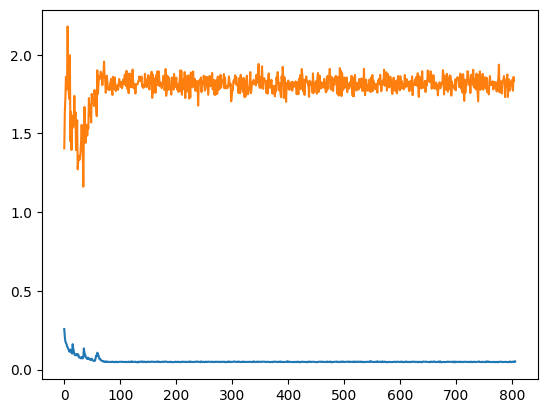

In [46]:
plt.plot(train_losses, label='train_losses')
plt.plot(eval_losses, label='valid_losses')

# Move the test_losses tensor to the CPU before plotting
# Convert the test_losses list to a NumPy array before plotting
plt.plot(np.array(test_losses), label='test_losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(frameon=True)
plt.title('Training, Validation, and Test Losses trend')
plt.show()